RMSE FeedbackDrivenQRC: 0.00135


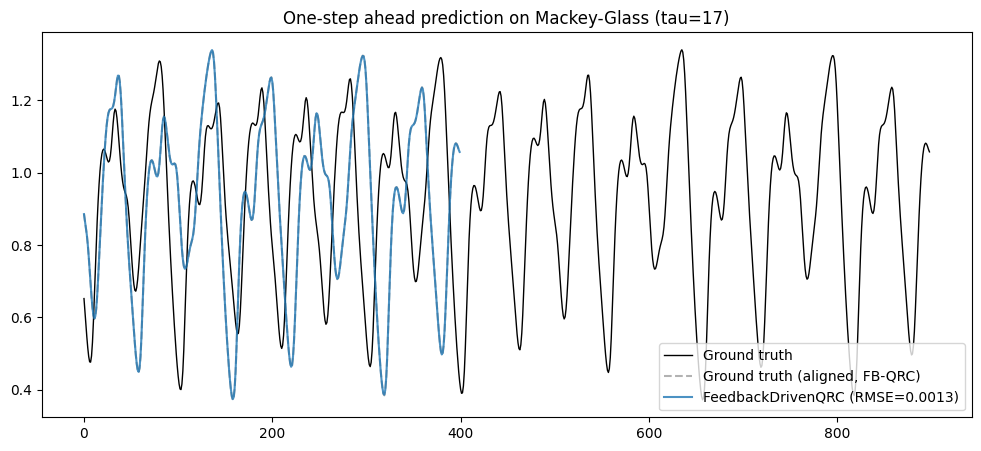

In [3]:
from datasets.mackey_glass import MackeyGlassDataset
from models.qrc_esn import QRC_ESN
from models.feedbackDriven import FeedbackDrivenQRC

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# używamy presetu Jaegera
dataset = MackeyGlassDataset(preset="jaeger_tau17", length=3000, seed=42)
series = dataset.generate()

# train/test split
train_frac = 0.7
split = int(len(series) * train_frac)
train_series, test_series = series[:split], series[split:]

# przygotowanie X,y do one-step ahead
X_train = train_series[:-1].reshape(-1, 1)
y_train = train_series[1:]
X_test = test_series[:-1].reshape(-1, 1)
y_test = test_series[1:]


# -----------------------------
# 3) FeedbackDrivenQRC
# -----------------------------
fb_model = FeedbackDrivenQRC(N=8, layers=7, ain=1e-3, afb=2.5)
fb_model.fit(train_series, y=train_series, warmup=500, ltr=1500)

y_pred_fb = fb_model.predict(test_series, warmup=500)
y_true_fb = test_series[500:500+len(y_pred_fb)]

rmse_fb = root_mean_squared_error(y_true_fb, y_pred_fb)

# -----------------------------
# 4) Wyniki + wykres
# -----------------------------
print(f"RMSE FeedbackDrivenQRC: {rmse_fb:.5f}")

plt.figure(figsize=(12,5))
plt.plot(y_test, label="Ground truth", color="black", linewidth=1)
plt.plot(y_true_fb, label="Ground truth (aligned, FB-QRC)", color="black", linestyle="--", alpha=0.3)
plt.plot(y_pred_fb, label=f"FeedbackDrivenQRC (RMSE={rmse_fb:.4f})", alpha=0.8)
plt.legend()
plt.title("One-step ahead prediction on Mackey-Glass (tau=17)")
plt.show()


# Model from notes notebook insted of feedbackdriven file

R^2 (test): 0.8643437760323615


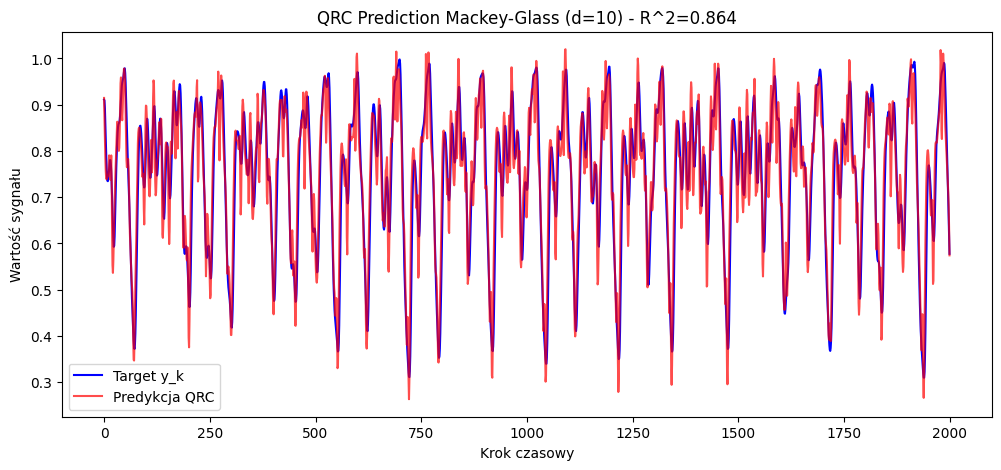

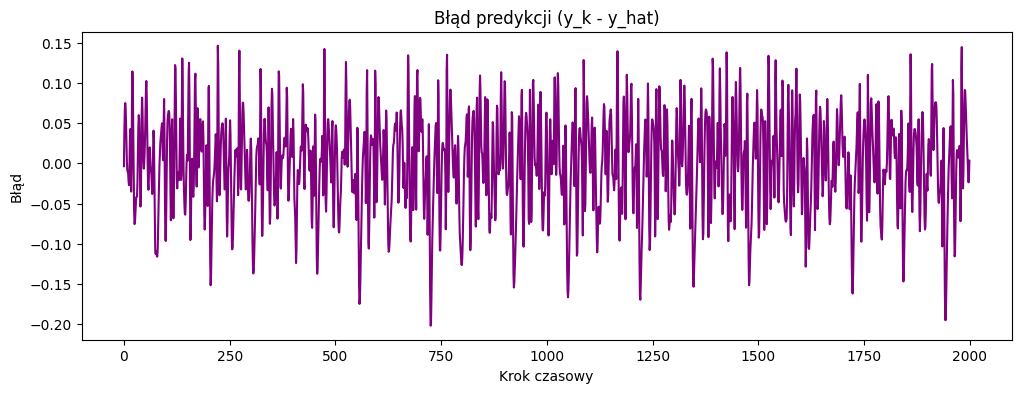

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np


# ----------------------------
# Mackey-Glass generator
# ----------------------------
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    N = int(T / dt)
    delay_steps = int(tau / dt)
    x = np.zeros(N + delay_steps)
    x[0:delay_steps] = 1.2

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]
        x[t + 1] = x[t] + dxdt * dt

    x_min, x_max = np.min(x), np.max(x)
    x = (x - x_min) / (x_max - x_min)
    return x[delay_steps:]

# ----------------------------
# QRC setup (Twój poprzedni kod)
# ----------------------------
N_qubits = 8
layers = 7
ain = 1e-3
afb = 2.0
seed = 42
rng = np.random.default_rng(seed)

dev = qml.device("default.qubit", wires=N_qubits, shots=None)

def R_ij(i, j, theta):
    qml.CNOT(wires=[i, j])
    qml.RZ(theta, wires=j)
    qml.CNOT(wires=[i, j])
    qml.RX(theta, wires=i)
    qml.RX(theta, wires=j)

def sample_reservoir_params(N, layers, rng):
    rots_kind = []
    rots_theta = []
    for _ in range(layers):
        kinds = rng.integers(0, 3, size=N)
        thetas = rng.uniform(0.0, 2*np.pi, size=N)
        rots_kind.append(kinds)
        rots_theta.append(thetas)
    return np.array(rots_kind), np.array(rots_theta)

rots_kind, rots_theta = sample_reservoir_params(N_qubits, layers, rng)

def apply_reservoir(N, layers, rots_kind, rots_theta):
    for w in range(N):
        qml.RY(np.pi/4, wires=w)
    for l in range(layers):
        for w in range(N):
            k = int(rots_kind[l, w])
            th = rots_theta[l, w]
            if k == 0:   qml.RX(th, wires=w)
            elif k == 1: qml.RY(th, wires=w)
            else:        qml.RZ(th, wires=w)
        for start in [0, 1]:
            for a in range(start, N-1, 2):
                qml.CNOT(wires=[a, a+1])

feedback_pairs = [(2,3),(3,4),(4,5),(5,6),(6,7),(7,2),(0,2),(1,3)]

@qml.qnode(dev)
def qrc_cycle(s_k, z_prev, ain, afb, rots_kind, rots_theta):
    R_ij(0, 1, ain * s_k)
    for alpha, (i,j) in enumerate(feedback_pairs):
        theta = afb * z_prev[alpha]
        R_ij(i, j, theta)
    apply_reservoir(N_qubits, layers, rots_kind, rots_theta)
    return [qml.expval(qml.PauliZ(w)) for w in range(N_qubits)]

def run_qrc(sequence, ain=ain, afb=afb, warmup=500, ltr=2000, lts=2000):
    L = len(sequence)
    assert L >= warmup + ltr + lts
    z_prev = rng.uniform(0.0, 1.0, size=N_qubits)
    Z_all = np.zeros((L, N_qubits))
    for k in range(L):
        z_k = np.array(qrc_cycle(sequence[k], z_prev, ain, afb, rots_kind, rots_theta), dtype=float)
        Z_all[k] = z_k
        z_prev = z_k
    def make_X(Z_slice):
        ones = np.ones((Z_slice.shape[0], 1))
        return np.hstack([Z_slice, ones])
    X_tr = make_X(Z_all[warmup:warmup+ltr])
    X_ts = make_X(Z_all[warmup+ltr:warmup+ltr+lts])
    return X_tr, X_ts

def r2(y, yhat):
    num = np.sum((y - yhat)**2)
    den = np.sum((y - np.mean(y))**2) + 1e-12
    return 1.0 - num/den

# ----------------------------
# 9) Generacja danych i trening
# ----------------------------
time_series = mackey_glass(beta=0.17, dt=1.5, T=7000, tau=30)

X_tr, X_ts = run_qrc(time_series, warmup=500, ltr=2000, lts=2000)

d = 10
y_tr = time_series[500-d : 500+2000-d]
y_ts = time_series[500+2000-d : 500+2000+2000-d]

w = np.linalg.pinv(X_tr) @ y_tr
y_hat = X_ts @ w

print("R^2 (test):", float(r2(y_ts, y_hat)))

# ----------------------------
# 10) Rysowanie wyników
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(y_ts, label="Target y_k", color="blue")
plt.plot(y_hat, label="Predykcja QRC", color="red", alpha=0.7)
plt.title(f"QRC Prediction Mackey-Glass (d={d}) - R^2={r2(y_ts, y_hat):.3f}")
plt.xlabel("Krok czasowy")
plt.ylabel("Wartość sygnału")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_ts - y_hat, color="purple")
plt.title("Błąd predykcji (y_k - y_hat)")
plt.xlabel("Krok czasowy")
plt.ylabel("Błąd")
plt.show()
